### Libraries

In [48]:
from gplearn.genetic import SymbolicTransformer
from gplearn.fitness import make_fitness
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

In [49]:
import cufflinks as cf
cf.go_offline()

In [50]:
%run ../../SVR_library/SVR_MAPE_Library.ipynb

### Load

In [51]:
path_consumo = Path().resolve().parents[1] / "Data" / "Data1.xlsx"
consumo = pd.read_excel(path_consumo)
consumo = consumo.set_index("fecha").loc["2007-01-01":"2020-03-30"]
X_path = Path().resolve().parents[1] / "Data" / "X_gp_transform.csv"
X = pd.read_csv(X_path).set_index("fecha")

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, consumo, test_size = 365, shuffle = False)

scaler = MaxAbsScaler(); scaler.fit(X_train); X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler1 = MaxAbsScaler(); scaler1.fit(y_train)
y_train = scaler1.transform(y_train).reshape(-1)

### functions

In [53]:
# custom metric
def _mape(y, y_pred, w):
    diffs = np.abs(np.divide((np.maximum(0.001, y) - np.maximum(0.001, y_pred)),np.maximum(0.001, y)))
    
    return 100. * np.average(diffs, weights=w)

mape = make_fitness(_mape, greater_is_better=False)

### model

In [59]:
function_set = ['add', 'sub', 'mul', 'div','sqrt', 'sin', 'cos', 'abs']
model = SymbolicTransformer(generations=40, population_size=20000,
                         hall_of_fame=100, n_components=20, 
                         init_method = "full", p_hoist_mutation = 0.05,
                         p_crossover = 0.6, p_subtree_mutation = 0.3,
                         function_set=function_set, metric = mape,
                         parsimony_coefficient=0.0001,
                         max_samples=0.95, verbose=1,
                         random_state=0)
model.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    15.90          90.1559        4          7.31187          7.45852     27.01m
   1    10.75          36.3104        4          7.28059          8.05186     25.95m
   2    10.76          30.3954       22          6.72985          5.94183     25.53m
   3    12.36           27.934       22          6.66201          7.22853     25.22m
   4    15.11          25.9314       25          6.28083          7.08714     26.52m
   5    14.80          24.1223       25          6.22591          6.51256     25.76m
   6    16.96          23.8615       27          6.19814          6.52275     25.70m
   7    27.42          20.0995       48          5.91146          6.07663     30.97m
   8    34.65          19.0116       48          5.88679          6.54463  

SymbolicTransformer(const_range=(-1.0, 1.0), feature_names=None,
                    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'sin',
                                  'cos', 'abs'],
                    generations=40, hall_of_fame=100, init_depth=(2, 6),
                    init_method='full', low_memory=False, max_samples=0.95,
                    metric=<gplearn.fitness._Fitness object at 0x00000298178A7388>,
                    n_components=20, n_jobs=1, p_crossover=0.6,
                    p_hoist_mutation=0.05, p_point_mutation=0.01,
                    p_point_replace=0.05, p_subtree_mutation=0.3,
                    parsimony_coefficient=0.0001, population_size=20000,
                    random_state=0, stopping_criteria=1.0, tournament_size=20,
                    verbose=1, warm_start=False)

In [60]:
import pickle

In [61]:
with open('GT_40it_20best_overfit.pkl', 'wb') as f:
    pickle.dump(model, f)

In [62]:
X_new = model.transform(X)
X_new = pd.DataFrame(X_new, index = X.index)

In [63]:
df = pd.concat([X_new, X], axis = 1)

In [64]:
df = df/df.max()

In [65]:
train_, test_ = train_test_split(X_train, shuffle = False, test_size = 365)

### fit

In [66]:
hyp = {'kernel': 'rbf',
 'C': 1.5622596668986724,
 'epsilon': 0.01,
 'mu': 0.8894683237212756,
 'lmbda': 0.7147423174236999,
 'gamma': 0.009632563464115184
      }

run = SVR_general_cvxopt(**hyp)
run.fit(X_train, y_train)

In [67]:
pred = run.predict(X_test)

In [70]:
pred = scaler1.inverse_transform(pred.reshape(-1, 1))

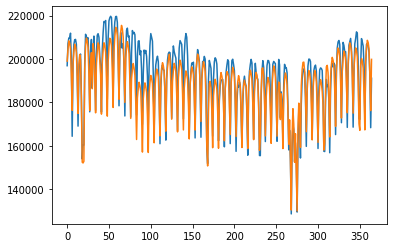

In [72]:
plt.plot(y_test.values)
plt.plot(pred)

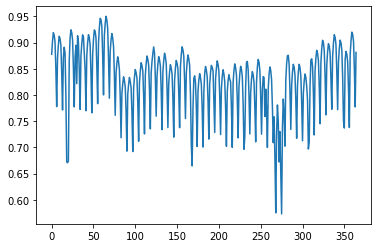

In [68]:
np.mean(y_test.values)

In [75]:
np.mean(np.abs((y_test - pred)/y_test))*100

MWh    2.897872
dtype: float64